In [1]:
using DrWatson
@quickactivate "MEngProject"
using MEngProject, CUDA, DifferentialEquations, PyPlot, NNlib,  ImageFiltering, Images, MEngProject, MEngProject.LamKernels, MEngProject.Laminart, MEngProject.Utils, BenchmarkTools, Test

UndefVarError: UndefVarError: LamKernels not defined

In [2]:
using OrdinaryDiffEq, ParameterizedFunctions, LSODA, Sundials, DiffEqDevTools

reshape2d_4d (generic function with 1 method)

In [3]:
img = convert(Array{Float32,2}, load(datadir("temp5_100_100_gs.png")));
img = LaminartGPU.reshape2d_4d(img)
img = cu(img)

r = similar(img)

p = LaminartGPU.kernels(img, Parameters.parameters);

LaminartGPU.I_u!(r, img, p)
temp_out = (I = img, r = r)
p = merge(p, temp_out);

tspan = (0.0f0, 100f0)
u0 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2,1));

arr1 = u0[:, :, 1:p.K,:]
arr2 = u0[:, :, 1:1,:];

f = LaminartGPU.LamFunction(
    similar(arr1), #x
    similar(arr1), #m
    similar(arr1), #s
 similar(arr2), #x_lgn,
similar(arr1), #C,
similar(arr1), #H_z,
similar(arr1), # dy_temp,
similar(arr1), # dm_temp,
similar(arr1), # dz_temp,
similar(arr1), # ds_temp,
similar(arr2), # dv_temp,
similar(arr1), # H_z_temp,
similar(arr2), #  V_temp_1,
similar(arr2), #  V_temp_2,
similar(arr1), #  A_temp,
similar(arr1), #   B_temp
    );

prob = ODEProblem(f, u0, tspan, p);

ArgumentError: ArgumentError: No file exists at given path: /mnt/storage_1/users/cullinanen/.julia/dev/MEngProject.jl/data/temp5_100_100_gs.png

In [4]:
sol = solve(prob);

UndefVarError: UndefVarError: prob not defined

In [69]:
@benchmark sol = solve(prob)

BenchmarkTools.Trial: 
  memory estimate:  149.43 MiB
  allocs estimate:  2906808
  --------------
  minimum time:     1.928 s (0.00% GC)
  median time:      2.038 s (2.19% GC)
  mean time:        2.003 s (2.04% GC)
  maximum time:     2.042 s (2.18% GC)
  --------------
  samples:          3
  evals/sample:     1

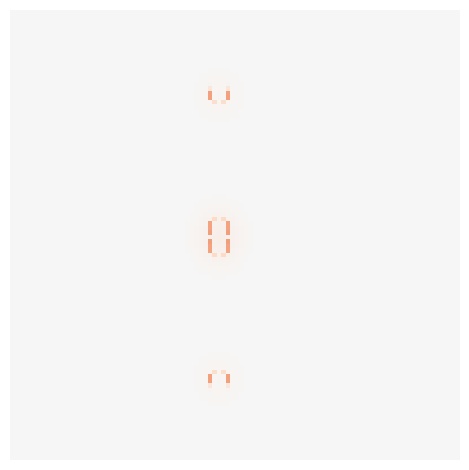

In [70]:
Utils.plot_rb(sol(100)[:,:,8,1])

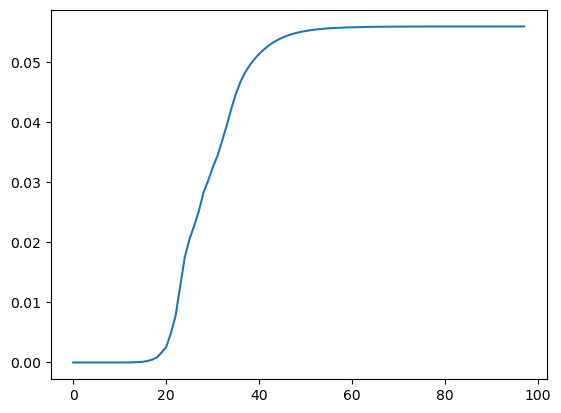

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff57d2e4850>

In [71]:
plot(sol[findmax(sol[:,:,7,1,end])[2][1],findmax(sol[:,:,7,1,end])[2][2],7,1,:])

In [84]:
sol_cpu = Array(sol)
u10 = sol(10)
sol = nothing;

MethodError: MethodError: no method matching Array(::Nothing)
Closest candidates are:
  Array(!Matched::LinearAlgebra.SymTridiagonal) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/LinearAlgebra/src/tridiag.jl:111
  Array(!Matched::LinearAlgebra.Tridiagonal) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/LinearAlgebra/src/tridiag.jl:528
  Array(!Matched::LinearAlgebra.AbstractTriangular) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/LinearAlgebra/src/triangular.jl:162
  ...

In [85]:
f_eq = LaminartGPU.LamFunction_equ(
    similar(arr1), #x
    similar(arr1), #m
    similar(arr1), #s
 similar(arr2), #x_lgn,
similar(arr1), #C,
similar(arr1), #H_z,
similar(arr1), # dy_temp,
similar(arr1), # dm_temp,
similar(arr1), # dz_temp,
similar(arr1), # ds_temp,
similar(arr2), # dv_temp,
similar(arr1), # H_z_temp,
similar(arr2), #  V_temp_1,
similar(arr2), #  V_temp_2,
similar(arr1), #  A_temp,
similar(arr1), #   B_temp
    );

prob = ODEProblem(f_eq, u10, tspan, p);

In [86]:
sol_eq10 = solve(prob);

In [87]:
@benchmark sol_10 = solve(prob)

BenchmarkTools.Trial: 
  memory estimate:  112.11 MiB
  allocs estimate:  2245076
  --------------
  minimum time:     1.528 s (0.00% GC)
  median time:      1.622 s (1.53% GC)
  mean time:        1.620 s (2.19% GC)
  maximum time:     1.707 s (5.39% GC)
  --------------
  samples:          4
  evals/sample:     1

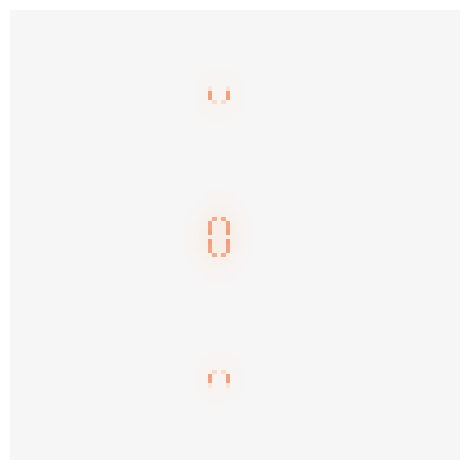

In [88]:
Utils.plot_rb(sol_eq10(100)[:,:,8,1])

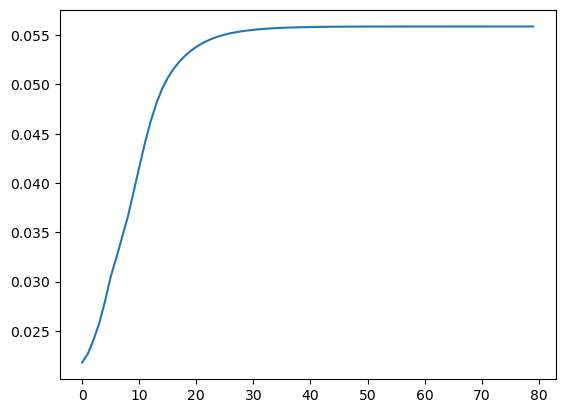

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff562889c90>

In [89]:
plot(sol_eq10[findmax(sol_eq10[:,:,7,1,end])[2][1],findmax(sol_eq10[:,:,7,1,end])[2][2],7,1,:])

In [91]:
sol_eq10_cpu = Array(sol_eq10)
sol_eq10 = nothing;

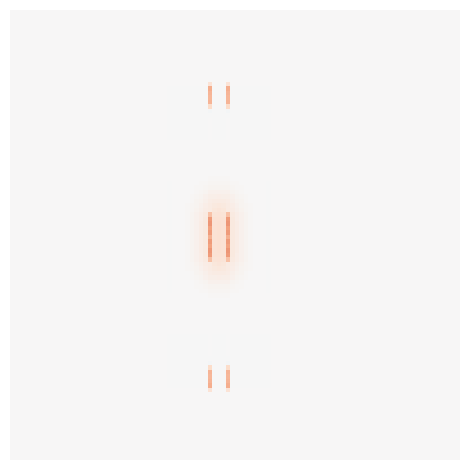

In [99]:
Utils.plot_rb(100f0 .* (sol_cpu[:,:,7,1,end] .- sol_eq10_cpu[:,:,7,1,end]))

In [98]:
findmax(sol_cpu[:,:,7,1,end] .- sol_eq10_cpu[:,:,7,1,end])

(0.004421193f0, CartesianIndex(48, 45))

In [101]:
max_diff = []
for l ∈ 5:12
    push!(max_diff, findmax(sol_cpu[:,:,l,1,end] .- sol_eq10_cpu[:,:,l,1,end]))
end

In [102]:
max_diff

8-element Array{Any,1}:
 (0.002510516f0, CartesianIndex(56, 45))
 (0.00012596996f0, CartesianIndex(50, 48))
 (0.004421193f0, CartesianIndex(48, 45))
 (0.0030102134f0, CartesianIndex(54, 45))
 (0.0f0, CartesianIndex(1, 1))
 (4.5619905f-5, CartesianIndex(21, 47))
 (2.026558f-6, CartesianIndex(23, 47))
 (0.0128147155f0, CartesianIndex(20, 45))

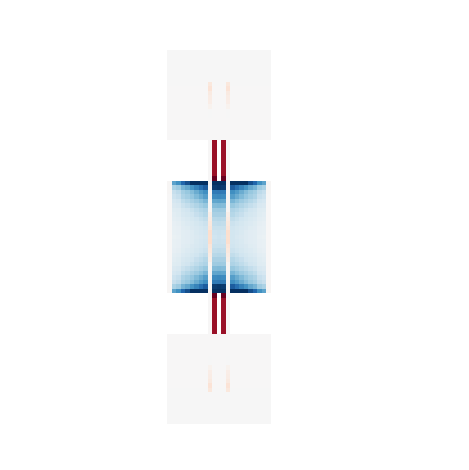

In [119]:
Utils.plot_rb((sol_cpu[:,:,7,1,end] .- sol_eq10_cpu[:,:,7,1,end]) ./ sol_cpu[:,:,7,1,end])

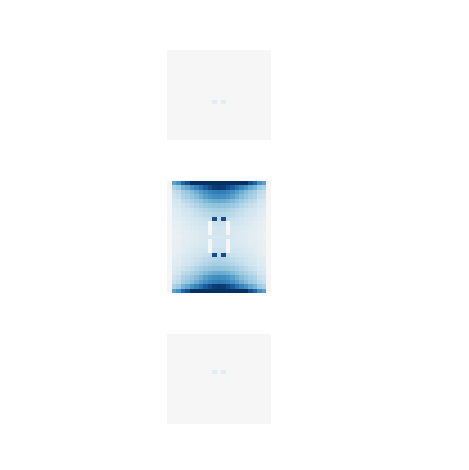

In [120]:
Utils.plot_rb((sol_cpu[:,:,8,1,end] .- sol_eq10_cpu[:,:,8,1,end]) ./ sol_cpu[:,:,8,1,end])

In [ ]:
# Solved eq from start

In [103]:
f_eq = LaminartGPU.LamFunction_equ(
    similar(arr1), #x
    similar(arr1), #m
    similar(arr1), #s
 similar(arr2), #x_lgn,
similar(arr1), #C,
similar(arr1), #H_z,
similar(arr1), # dy_temp,
similar(arr1), # dm_temp,
similar(arr1), # dz_temp,
similar(arr1), # ds_temp,
similar(arr2), # dv_temp,
similar(arr1), # H_z_temp,
similar(arr2), #  V_temp_1,
similar(arr2), #  V_temp_2,
similar(arr1), #  A_temp,
similar(arr1), #   B_temp
    );

prob = ODEProblem(f_eq, u0, tspan, p);

In [104]:
sol_eq0 = solve(prob);

In [105]:
@benchmark sol_eq0 = solve(prob)

BenchmarkTools.Trial: 
  memory estimate:  131.71 MiB
  allocs estimate:  2630015
  --------------
  minimum time:     1.836 s (0.00% GC)
  median time:      1.916 s (2.43% GC)
  mean time:        1.908 s (1.66% GC)
  maximum time:     1.971 s (2.44% GC)
  --------------
  samples:          3
  evals/sample:     1

In [106]:
sol_eq0_cpu = Array(sol_eq0)
sol_eq0 = nothing;

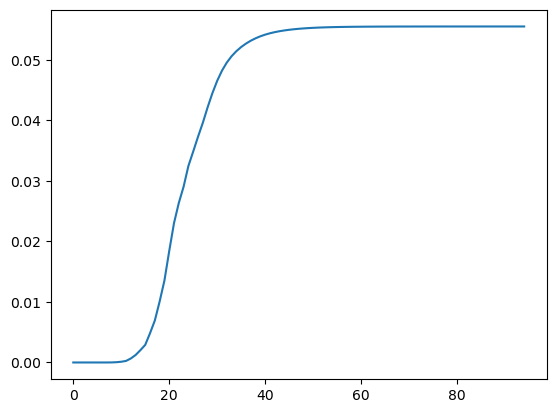

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff57d293e90>

In [107]:
plot(sol_eq0_cpu[findmax(sol_eq0_cpu[:,:,7,1,end])[2][1],findmax(sol_eq0_cpu[:,:,7,1,end])[2][2],7,1,:])

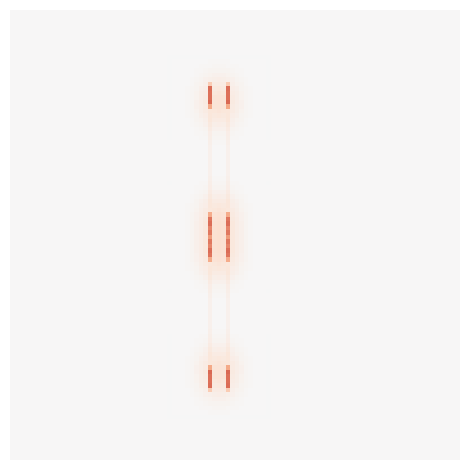

In [108]:
Utils.plot_rb(100f0 .* (sol_cpu[:,:,7,1,end] .- sol_eq0_cpu[:,:,7,1,end]))

In [109]:
findmax(sol_cpu[:,:,7,1,end] .- sol_eq0_cpu[:,:,7,1,end])

(0.0057554953f0, CartesianIndex(81, 45))

In [110]:
max_diff = []
for l ∈ 5:12
    push!(max_diff, findmax(sol_cpu[:,:,l,1,end] .- sol_eq0_cpu[:,:,l,1,end]))
end

In [111]:
max_diff

8-element Array{Any,1}:
 (0.002573837f0, CartesianIndex(46, 45))
 (3.4479337f-5, CartesianIndex(50, 48))
 (0.0057554953f0, CartesianIndex(81, 45))
 (0.0014305711f0, CartesianIndex(20, 45))
 (0.0f0, CartesianIndex(1, 1))
 (1.5139114f-5, CartesianIndex(11, 47))
 (0.0f0, CartesianIndex(1, 1))
 (0.016760632f0, CartesianIndex(20, 45))

In [115]:
sol_cpu[81,45,7,1,end]

0.05370479f0

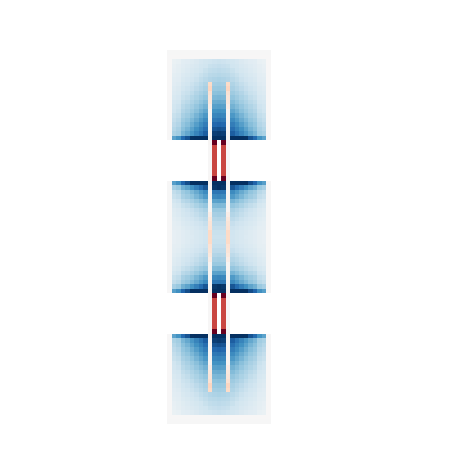

In [117]:
Utils.plot_rb((sol_cpu[:,:,7,1,end] .- sol_eq0_cpu[:,:,7,1,end]) ./ sol_cpu[:,:,7,1,end])

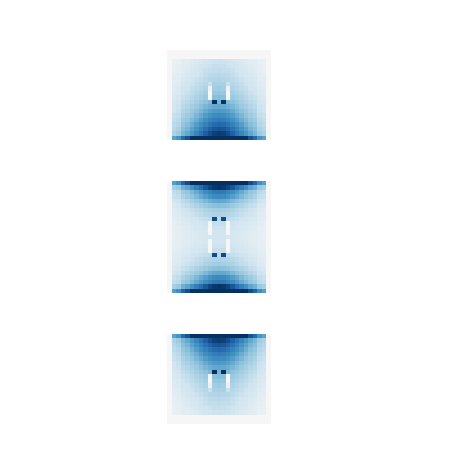

In [118]:
Utils.plot_rb((sol_cpu[:,:,8,1,end] .- sol_eq0_cpu[:,:,8,1,end]) ./ sol_cpu[:,:,8,1,end])

In [161]:
du = similar(u0)

100×100×12×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.

In [167]:
@benchmark f(du, u0, p, 1) # all

BenchmarkTools.Trial: 
  memory estimate:  196.83 KiB
  allocs estimate:  3813
  --------------
  minimum time:     2.160 ms (0.00% GC)
  median time:      2.275 ms (0.00% GC)
  mean time:        2.396 ms (2.41% GC)
  maximum time:     112.471 ms (60.43% GC)
  --------------
  samples:          2079
  evals/sample:     1

In [169]:
@benchmark f(du, u0, p, 1) # no y, m

BenchmarkTools.Trial: 
  memory estimate:  189.64 KiB
  allocs estimate:  3670
  --------------
  minimum time:     2.091 ms (0.00% GC)
  median time:      2.146 ms (0.00% GC)
  mean time:        2.278 ms (2.84% GC)
  maximum time:     130.647 ms (64.85% GC)
  --------------
  samples:          2186
  evals/sample:     1

In [171]:
@benchmark f(du, u0, p, 1) # no z,s

BenchmarkTools.Trial: 
  memory estimate:  189.64 KiB
  allocs estimate:  3670
  --------------
  minimum time:     2.087 ms (0.00% GC)
  median time:      2.134 ms (0.00% GC)
  mean time:        2.231 ms (2.08% GC)
  maximum time:     98.508 ms (53.09% GC)
  --------------
  samples:          2232
  evals/sample:     1

In [173]:
@benchmark f(du, u0, p, 1) # no func

BenchmarkTools.Trial: 
  memory estimate:  15.69 KiB
  allocs estimate:  322
  --------------
  minimum time:     210.745 μs (0.00% GC)
  median time:      219.643 μs (0.00% GC)
  mean time:        220.888 μs (0.00% GC)
  maximum time:     3.478 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [177]:
@benchmark f(du, u0, p, 1) # only xy

BenchmarkTools.Trial: 
  memory estimate:  64.88 KiB
  allocs estimate:  1110
  --------------
  minimum time:     738.263 μs (0.00% GC)
  median time:      781.052 μs (0.00% GC)
  mean time:        813.965 μs (1.64% GC)
  maximum time:     55.864 ms (72.59% GC)
  --------------
  samples:          6078
  evals/sample:     1

In [179]:
@benchmark f(du, u0, p, 1) # only xlgn

BenchmarkTools.Trial: 
  memory estimate:  22.52 KiB
  allocs estimate:  514
  --------------
  minimum time:     292.552 μs (0.00% GC)
  median time:      303.925 μs (0.00% GC)
  mean time:        313.962 μs (1.69% GC)
  maximum time:     91.785 ms (57.80% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [181]:
@benchmark f(du, u0, p, 1) # only C

BenchmarkTools.Trial: 
  memory estimate:  53.23 KiB
  allocs estimate:  1173
  --------------
  minimum time:     665.341 μs (0.00% GC)
  median time:      686.925 μs (0.00% GC)
  mean time:        720.661 μs (2.82% GC)
  maximum time:     134.103 ms (66.30% GC)
  --------------
  samples:          7043
  evals/sample:     1

In [183]:
@benchmark f(du, u0, p, 1) # only H

BenchmarkTools.Trial: 
  memory estimate:  27.36 KiB
  allocs estimate:  612
  --------------
  minimum time:     377.679 μs (0.00% GC)
  median time:      460.260 μs (0.00% GC)
  mean time:        460.483 μs (1.65% GC)
  maximum time:     107.901 ms (70.59% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [185]:
@benchmark f(du, u0, p, 1) # only dv

BenchmarkTools.Trial: 
  memory estimate:  27.36 KiB
  allocs estimate:  612
  --------------
  minimum time:     378.075 μs (0.00% GC)
  median time:      462.334 μs (0.00% GC)
  mean time:        458.522 μs (1.09% GC)
  maximum time:     81.020 ms (61.78% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [ ]:
@benchmark f(du, u0, p, 1) # only H